In [ ]:
# advance neuro project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import torch

In [2]:
# select the device to run the code on
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

In [3]:
def ReLU(x):
    zeros_mat = torch.zeros(x.shape, device=dev)
    output = torch.fmax(x, zeros_mat)
    return output

In [4]:
def ReLU_deriv(x):
    non_negs = torch.where(x >= 0)
    output = torch.zeros(x.shape, device=dev)
    output[non_negs] = 1
    return output

In [5]:
def angleCal(A, B):
    num = torch.trace(torch.matmul(torch.conj(A.T), B))
    norm_A = math.sqrt(torch.trace(torch.matmul(A,torch.conj(A.T))))
    norm_B = math.sqrt(torch.trace(torch.matmul(B,torch.conj(B.T))))
    denum = norm_A*norm_B
    angle = torch.arccos(num/denum)*180/math.pi
    return angle

In [6]:
#### network parameters - open loop 2 layer network - first condition - auto correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles1 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)
    
    # input layer values - # move on gpu
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) # initial value of inputs - constant during iterations
    error_delta2 = torch.normal(mu, sigma, size=(n_b, output_layer_size), device=dev) # initial value of error_delta 2 - constant during iterations
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
    
    for j in range (number_of_iterations):
        angles1[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


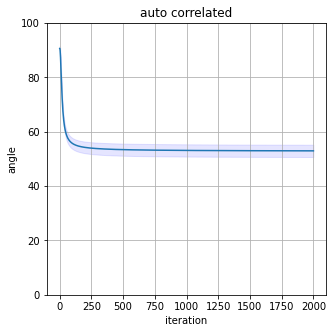

In [7]:
## plot the result of auto correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5));
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1.cpu().numpy(),0));
ax.set_ylim([0, 100]);
ax.set_title('auto correlated');
ax.set_ylabel('angle');
ax.set_xlabel('iteration');
ax.grid(True);

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1.cpu().numpy(),0)-np.std(angles1.cpu().numpy(),axis=0),\
                np.mean(angles1.cpu().numpy(),0)+np.std(angles1.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [8]:
#### network parameters - open loop 2 layer network - second condition - cross correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles2 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta2 = torch.clone(input_layer) # cross correlated with inputs of network
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
    
    for j in range (number_of_iterations):
        angles2[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = torch.clone(error_delta2)
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
        error_delta2 = torch.clone(input_layer)
        error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


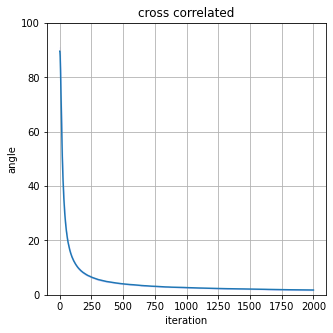

In [9]:
# plot the result of cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2.cpu().numpy(),0)-np.std(angles2.cpu().numpy(),axis=0),\
                np.mean(angles2.cpu().numpy(),0)+np.std(angles2.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [10]:
#### network parameters - open loop 2 layer network - third condition - not auto correlated nor cross correlated

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles3 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta2 = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta1 = torch.matmul(error_delta2, backward_weight_1)

    for j in range (number_of_iterations):
        angles3[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(forward_weight_0.T, input_layer.T).T
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
        error_delta2 = torch.normal(mu, sigma, size=(n_b, output_layer_size), device=dev) 
        error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


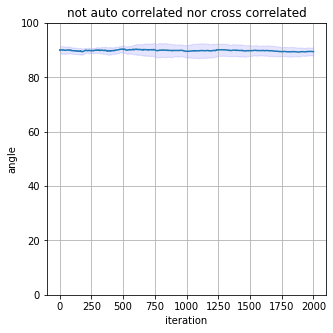

In [11]:
# plot the result of not auto correlated nor cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('not auto correlated nor cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3.cpu().numpy(),0)-np.std(angles3.cpu().numpy(),axis=0),\
                np.mean(angles3.cpu().numpy(),0)+np.std(angles3.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [12]:
#### network parameters - open loop 2 layer network - forth condition - auto correlated & cross correlated

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles4 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) # initial value of inputs - constant during iterations
    error_delta2 = input_layer # initial value of error_delta 2 - constant during iterations
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
    # delta 2 doesn't change

    for j in range (number_of_iterations):
        angles4[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


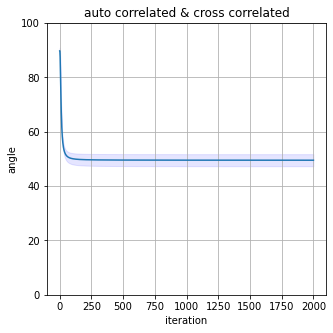

In [13]:
# plot the result of auto correlated & cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles4.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('auto correlated & cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles4.cpu().numpy(),0)-np.std(angles4.cpu().numpy(),axis=0),\
                np.mean(angles4.cpu().numpy(),0)+np.std(angles4.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


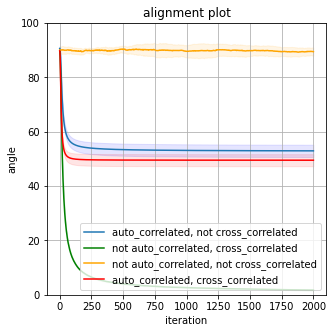

In [14]:
# plot the result of all three conditions together

    
fig, ax = plt.subplots(1,1,figsize=(5,5))

# condition 1
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence1 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1.cpu().numpy(),0)-np.std(angles1.cpu().numpy(),axis=0),\
                np.mean(angles1.cpu().numpy(),0)+np.std(angles1.cpu().numpy(),axis=0),\
                color='b', alpha=.1);

# condition 2
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2.cpu().numpy(),0),color='green')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence2 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2.cpu().numpy(),0)-np.std(angles2.cpu().numpy(),axis=0),\
                np.mean(angles2.cpu().numpy(),0)+np.std(angles2.cpu().numpy(),axis=0),\
                color='green', alpha=.1);

# condition 3
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3.cpu().numpy(),0),color='orange')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence3 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3.cpu().numpy(),0)-np.std(angles3.cpu().numpy(),axis=0),\
                np.mean(angles3.cpu().numpy(),0)+np.std(angles3.cpu().numpy(),axis=0),\
                color='orange', alpha=.1);

# condition 4
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles4.cpu().numpy(),0),color='red')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence4 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles4.cpu().numpy(),0)-np.std(angles4.cpu().numpy(),axis=0),\
                np.mean(angles4.cpu().numpy(),0)+np.std(angles4.cpu().numpy(),axis=0),\
                color='red', alpha=.1);

ax.legend(['auto_correlated, not cross_correlated','not auto_correlated, cross_correlated',\
           'not auto_correlated, not cross_correlated',\
          'auto_correlated, cross_correlated'],loc='lower right')

In [15]:
# Paper Part - 2.3 Using the provided theoretical tool to investigate FA in the learning process of a practical deep ANN
# train and test a 5 layer network on MNIST
# fact = tanh(ReLU) - 50 neurons in all hidden and output layer - output layer is using 5 hot coding
# images of MNIST should be resized to 15*15 - so we have 225 neurons in input layer 
# inputs should be normalized 
# batch size = 1000, 60 batches available (total numbre of 60K images)
# initialization of forward/ backward weights and biases is done using N(0,0.1)
# loss function is sth like squared error, check page 5 for the details

In [6]:
def n_hot_coder(x,n,hot_labels,output_neuron_num):
    labels = x.cpu().numpy()
    category_num = 10
    if(category_num*n > output_neuron_num):
        print('nhot encoding can`t be done since the condition`s not met')
        return false
    
    output = torch.zeros((len(x),output_neuron_num), device=dev)
    
    output[np.where(labels == 0),:] = hot_labels[0,:]
    output[np.where(labels == 1),:] = hot_labels[1,:]
    output[np.where(labels == 2),:] = hot_labels[2,:]
    output[np.where(labels == 3),:] = hot_labels[3,:]
    output[np.where(labels == 4),:] = hot_labels[4,:]
    output[np.where(labels == 5),:] = hot_labels[5,:]
    output[np.where(labels == 6),:] = hot_labels[6,:]
    output[np.where(labels == 7),:] = hot_labels[7,:]
    output[np.where(labels == 8),:] = hot_labels[8,:]
    output[np.where(labels == 9),:] = hot_labels[9,:]

    return output

In [7]:
def loss_function(output_layer,labels):
    difference = labels-output_layer
    output = 0.5*(torch.sum(difference**2))
    return output

In [8]:
def tanh_Relu_deriv(x):
    non_negs = torch.where(x > 0)
    output = torch.zeros(x.shape, device=dev)
    output[non_negs] = 1-torch.tanh(x[non_negs])**2
    return output

In [9]:
def binarize_output(output,n,categories_nhot):
  
    binarized = torch.zeros((output.shape[0],output.shape[1]), device=dev)
    current_data_scores = torch.matmul(output,categories_nhot.T)
    _, closest_label = torch.max(current_data_scores,dim=1)
    binarized = categories_nhot[closest_label,:]
    
    return binarized

In [10]:
def accuracy_cal(output,label):
    acc = 0
    
    compare = output.shape[1]*torch.ones((output.shape[0]), device=dev)
    acc = torch.sum(torch.eq(torch.sum(torch.eq(output,label),dim=1),compare))
  
    acc = acc/len(output)*100 # in percentage
    return acc

In [11]:
def alignment_term_cal(epoch_num,batch_num,layer_num,LR,B1,B2,B3,B4,delta5_inTime,delta4_inTime,delta3_inTime,\
                      delta2_inTime,delta1_inTime,input_layer,hidden_layer1_inTime,hidden_layer2_inTime,\
                      hidden_layer3_inTime,hidden_layer4_inTime):

    alignment_terms = [];
    
    iter_needed = 1260
    
    # cal alignment terms
    for i in range(1,iter_needed): # iteration
        print(i)
        o = 0
        torch.cuda.empty_cache()
        alignment_terms_k = torch.zeros((i,layer_num,output_layer_size,output_layer_size), device=dev)
        while (o < i):
            # l1
            term1 = torch.matmul(B1.T,delta2_inTime[i-o-1,:,:].T)
            term2 = torch.matmul(input_layer[np.mod(i-o-1,batch_num),:,:],input_layer[np.mod(i,batch_num),:,:].T)
            term3 = delta2_inTime[i,:,:]
            term4 = torch.matmul(term1,term2)
            alignment_terms_k[o,0,:,:] = (LR**2)*torch.matmul(term4,term3)
            # l2
            term1 = torch.matmul(B2.T,delta3_inTime[i-o-1,:,:].T)
            term2 = torch.matmul(hidden_layer1_inTime[i,:,:],hidden_layer1_inTime[i,:,:].T)
            term3 = delta3_inTime[i,:,:]
            term4 = torch.matmul(term1,term2)
            alignment_terms_k[o,1,:,:] = (LR**2)*torch.matmul(term4,term3)
            # l3
            term1 = torch.matmul(B3.T,delta4_inTime[i-o-1,:,:].T)
            term2 = torch.matmul(hidden_layer2_inTime[i,:,:],hidden_layer2_inTime[i,:,:].T)
            term3 = delta4_inTime[i,:,:]
            term4 = torch.matmul(term1,term2)
            alignment_terms_k[o,2,:,:] = (LR**2)*torch.matmul(term4,term3)
            # l4
            term1 = torch.matmul(B4.T,delta5_inTime[i-o-1,:,:].T)
            term2 = torch.matmul(hidden_layer3_inTime[i,:,:],hidden_layer3_inTime[i,:,:].T)
            term3 = delta4_inTime[i,:,:]
            term4 = torch.matmul(term1,term2)
            alignment_terms_k[o,3,:,:] = (LR**2)*torch.matmul(term4,term3)
            
            o += 1
        
        alignment_terms.append(alignment_terms_k)
        
    return alignment_terms

In [12]:
# Load MNIST Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

# loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert images to pytorch tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

print('data loaded!')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


11501568/11490434 [==============================] - 0s 0us/step
data loaded!
torch.Size([60000, 28, 28]) torch.Size([60000]) torch.Size([10000, 28, 28]) torch.Size([10000])


In [13]:
# resize images to 15*15
from torchvision import transforms as trans
import torchvision.transforms.functional as Func

x_train_resized = torch.zeros((x_train.shape[0],15,15))
x_test_resized = torch.zeros((x_test.shape[0],15,15))
resize_trans = trans.Resize(15)

# resize train images
for i in range (x_train.shape[0]):
    image = x_train[i,:,:].unsqueeze(0)
    x_train_resized[i,:,:] = resize_trans(image)

    
# resize test images
for i in range (x_test.shape[0]):
    image = x_test[i,:,:].unsqueeze(0)
    x_test_resized[i,:,:] = resize_trans(image)
    
print('resizing done!')
print(x_train_resized.shape,x_test_resized.shape)


resizing done!
torch.Size([60000, 15, 15]) torch.Size([10000, 15, 15])


In [14]:
# convert images and labels to pytorch tensors & vectorize them

x_train_flat = x_train_resized.reshape(x_train_resized.shape[0],-1)
x_test_flat = x_test_resized.reshape(x_test_resized.shape[0],-1)

x_train_flat = x_train_flat.to(dev)
x_test_flat = x_test_flat.to(dev)
y_train = y_train.to(dev)
y_test = y_test.to(dev)

print('vectorization done!')
print(x_train_flat.shape,x_test_flat.shape)

vectorization done!
torch.Size([60000, 225]) torch.Size([10000, 225])


In [15]:
# normalize images

x_tr_norm = x_train_flat/255
x_te_norm  = x_test_flat/255


print('normalization done!')

normalization done!


In [16]:
# n hot coding the labels
category_num = 10
output_neuron_num = 50
n = int(output_neuron_num/category_num)

# encoding the categroies
categories_nhot = torch.zeros((category_num,output_neuron_num), device=dev)
codes = torch.randperm(output_neuron_num, device=dev)

for i in range(category_num):
    categories_nhot[i,codes[i*n:(i+1)*n]] = 1 
    
y_train_nhot = n_hot_coder(y_train,n,categories_nhot,output_neuron_num)
y_test_nhot = n_hot_coder(y_test,n,categories_nhot,output_neuron_num)

print('n hot coding done!')
print(y_train_nhot.shape, y_test_nhot.shape)


n hot coding done!
torch.Size([60000, 50]) torch.Size([10000, 50])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  # Remove the CWD from sys.path while we load stuff.


In [17]:
# create the network weights and biases from N(0,0.1)
mu = 0
sigma = 0.1

# each layer size
input_layer_size = 225
hidden_layer1_size = 50
hidden_layer2_size = 50
hidden_layer3_size = 50
hidden_layer4_size = 50
output_layer_size = 50

# forward weights
w0 = torch.normal(mu,sigma,size=(input_layer_size,hidden_layer1_size), device=dev)
w1 = torch.normal(mu,sigma,size=(hidden_layer1_size,hidden_layer2_size), device=dev)
w2 = torch.normal(mu,sigma,size=(hidden_layer2_size,hidden_layer3_size), device=dev)
w3 = torch.normal(mu,sigma,size=(hidden_layer3_size,hidden_layer4_size), device=dev)
w4 = torch.normal(mu,sigma,size=(hidden_layer4_size,output_layer_size), device=dev)

# backward weights
B4 = torch.normal(mu,sigma,size=(output_layer_size,hidden_layer4_size), device=dev)
B3 = torch.normal(mu,sigma,size=(hidden_layer4_size,hidden_layer3_size), device=dev)
B2 = torch.normal(mu,sigma,size=(hidden_layer3_size,hidden_layer2_size), device=dev)
B1 = torch.normal(mu,sigma,size=(hidden_layer2_size,hidden_layer1_size), device=dev)

# bias vectors
b1 =  torch.normal(mu,sigma,size=(1,hidden_layer1_size), device=dev)
b2 =  torch.normal(mu,sigma,size=(1,hidden_layer2_size), device=dev)
b3 =  torch.normal(mu,sigma,size=(1,hidden_layer3_size), device=dev)
b4 =  torch.normal(mu,sigma,size=(1,hidden_layer4_size), device=dev)
b5 =  torch.normal(mu,sigma,size=(1,output_layer_size), device=dev)

print('network parameters created!')

network parameters created!


In [18]:
import pandas as pd

# run the network - run prev part to initialize the paramters each time

LR = 0.0005
batch_size = 1000
batch_num = 60
layer_num = 4
im_size = 15*15
input_layer = x_tr_norm.reshape((batch_num,batch_size,im_size))
epoch_num = 100
accuracy_training = torch.zeros((batch_num,epoch_num), device=dev)
loss_training = torch.zeros((batch_num,epoch_num), device=dev)

# angle between B & W
alignment = torch.zeros((4,batch_num,epoch_num), device=dev)


# layer and delta values in iterations for calculating alignment terms
iter_needed = 1260
hidden_layer1_inTime = torch.zeros((iter_needed,batch_size,hidden_layer1_size), device=dev)
hidden_layer2_inTime = torch.zeros((iter_needed,batch_size,hidden_layer2_size), device=dev)
hidden_layer3_inTime = torch.zeros((iter_needed,batch_size,hidden_layer3_size), device=dev)
hidden_layer4_inTime = torch.zeros((iter_needed,batch_size,hidden_layer4_size), device=dev)
output_layer_inTime = torch.zeros((iter_needed,batch_size,output_layer_size), device=dev)
delta5_inTime = torch.zeros((iter_needed,batch_size,output_layer_size), device=dev)
delta4_inTime = torch.zeros((iter_needed,batch_size,hidden_layer4_size), device=dev)
delta3_inTime = torch.zeros((iter_needed,batch_size,hidden_layer3_size), device=dev)
delta2_inTime = torch.zeros((iter_needed,batch_size,hidden_layer2_size), device=dev)
delta1_inTime = torch.zeros((iter_needed,batch_size,hidden_layer1_size), device=dev)




for j in range(epoch_num):
    for i in range(batch_num):
        # forward
        z1 = torch.matmul(input_layer[i,:,:],w0) + b1
        hidden_layer1 = torch.tanh(ReLU(z1))
        z2 = torch.matmul(hidden_layer1,w1) + b2
        hidden_layer2 = torch.tanh(ReLU(z2))
        z3 = torch.matmul(hidden_layer2,w2) + b3
        hidden_layer3 = torch.tanh(ReLU(z3))
        z4 = torch.matmul(hidden_layer3,w3) + b4
        hidden_layer4 = torch.tanh(ReLU(z4))
        z5 = torch.matmul(hidden_layer4,w4) + b5
        output_layer = torch.tanh(ReLU(z5))
        
        # backward the error
        E = y_train_nhot[i*batch_size:(i+1)*batch_size,:]-output_layer
        delta5 = torch.multiply(E,tanh_Relu_deriv(z5))
        delta4 = torch.multiply(torch.matmul(delta5,B4),tanh_Relu_deriv(z4))
        delta3 = torch.multiply(torch.matmul(delta4,B3),tanh_Relu_deriv(z3))
        delta2 = torch.multiply(torch.matmul(delta3,B2),tanh_Relu_deriv(z2))
        delta1 = torch.multiply(torch.matmul(delta2,B1),tanh_Relu_deriv(z1))
        
        # save values in time for calculating alignment terms - just up to iteration 1260
        if(j*batch_num+i < 1260):
            hidden_layer1_inTime[j*batch_num+i,:,:] = hidden_layer1
            hidden_layer2_inTime[j*batch_num+i,:,:] = hidden_layer2
            hidden_layer3_inTime[j*batch_num+i,:,:] = hidden_layer3
            hidden_layer4_inTime[j*batch_num+i,:,:] = hidden_layer4
            output_layer_inTime[j*batch_num+i,:,:] = output_layer
            delta5_inTime[j*batch_num+i,:,:] = delta5
            delta4_inTime[j*batch_num+i,:,:] = delta4
            delta3_inTime[j*batch_num+i,:,:] = delta3
            delta2_inTime[j*batch_num+i,:,:] = delta2
            delta1_inTime[j*batch_num+i,:,:] = delta1
            
        
        # update forward weights 
        w4 += LR*torch.matmul(hidden_layer4.T,delta5)
        w3 += LR*torch.matmul(hidden_layer3.T,delta4)
        w2 += LR*torch.matmul(hidden_layer2.T,delta3)
        w1 += LR*torch.matmul(hidden_layer1.T,delta2)
        w0 += LR*torch.matmul(input_layer[i,:,:].T,delta1)
        
        # update biases
        J = torch.ones((1,batch_size), device=dev)
        b5 += torch.squeeze(LR*torch.matmul(J,delta5))
        b4 += torch.squeeze(LR*torch.matmul(J,delta4))
        b3 += torch.squeeze(LR*torch.matmul(J,delta3))
        b2 += torch.squeeze(LR*torch.matmul(J,delta2))
        b1 += torch.squeeze(LR*torch.matmul(J,delta1))
        
        # binarize output
        n = 5 # n hot
        output_layer_binarized = binarize_output(output_layer,n,categories_nhot)

        # loss values
        loss_training[i,j] = loss_function(output_layer,y_train_nhot[i*batch_size:(i+1)*batch_size,:])
        accuracy_training[i,j] = accuracy_cal(output_layer_binarized,y_train_nhot[i*batch_size:(i+1)*batch_size,:]);
        
        # cal the angle between B & W
        alignment[0,i,j] = angleCal(w1,B1.T)
        alignment[1,i,j] = angleCal(w2,B2.T) 
        alignment[2,i,j] = angleCal(w3,B3.T) 
        alignment[3,i,j] = angleCal(w4,B4.T) 
    
    print(torch.mean(accuracy_training[:,j]),torch.mean(loss_training[:,j]))

print('network training done!')

tensor(18.9750, device='cuda:0') tensor(2296.5142, device='cuda:0')
tensor(37.3433, device='cuda:0') tensor(2005.5027, device='cuda:0')
tensor(57.4267, device='cuda:0') tensor(1650.2534, device='cuda:0')
tensor(66.9100, device='cuda:0') tensor(1430.2651, device='cuda:0')
tensor(71.4000, device='cuda:0') tensor(1320.3439, device='cuda:0')
tensor(74.6317, device='cuda:0') tensor(1240.2716, device='cuda:0')
tensor(77.1233, device='cuda:0') tensor(1168.5668, device='cuda:0')
tensor(79.0000, device='cuda:0') tensor(1098.7330, device='cuda:0')
tensor(80.7067, device='cuda:0') tensor(1049.4484, device='cuda:0')
tensor(81.9617, device='cuda:0') tensor(1010.8019, device='cuda:0')
tensor(82.8800, device='cuda:0') tensor(980.0233, device='cuda:0')
tensor(83.6300, device='cuda:0') tensor(955.5678, device='cuda:0')
tensor(84.1817, device='cuda:0') tensor(935.7933, device='cuda:0')
tensor(84.6433, device='cuda:0') tensor(919.4158, device='cuda:0')
tensor(85.0783, device='cuda:0') tensor(905.2814, de

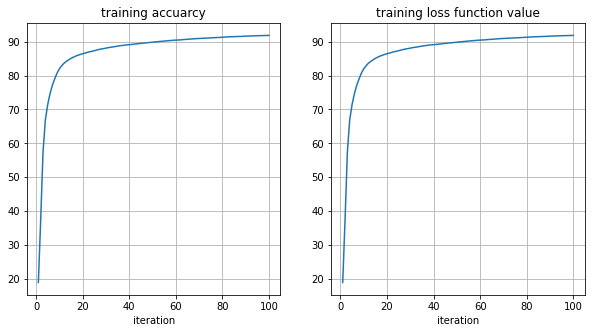

In [19]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(np.arange(1,epoch_num+1),np.mean(accuracy_training.cpu().numpy(),axis=0))
ax[1].plot(np.arange(1,epoch_num+1),np.mean(accuracy_training.cpu().numpy(),axis=0))
ax[0].set_title('training accuarcy')
ax[0].set_xlabel('iteration')
ax[1].set_title('training loss function value')
ax[1].set_xlabel('iteration')
ax[0].grid(True)
ax[1].grid(True)

In [20]:
import pandas as pd

# accuracy on test data

batch_size = 1
batch_num = int(x_te_norm.shape[0]/batch_size)
im_size = 15*15
input_layer = x_te_norm.reshape((batch_num,batch_size,im_size))
accuracy_training = torch.zeros((batch_num), device=dev)
loss_training = torch.zeros((batch_num), device=dev)

for i in range(batch_num):
    # forward
    z1 = torch.matmul(input_layer[i,:,:],w0) + b1
    hidden_layer1 = torch.tanh(ReLU(z1))
    z2 = torch.matmul(hidden_layer1,w1) + b2
    hidden_layer2 = torch.tanh(ReLU(z2))
    z3 = torch.matmul(hidden_layer2,w2) + b3
    hidden_layer3 = torch.tanh(ReLU(z3))
    z4 = torch.matmul(hidden_layer3,w3) + b4
    hidden_layer4 = torch.tanh(ReLU(z4))
    z5 = torch.matmul(hidden_layer4,w4) + b5
    output_layer = torch.tanh(ReLU(z5))

    # binarize output
    n = 5
    output_layer_binarized = binarize_output(output_layer,n,categories_nhot)
    
    # loss val and accuracy
    loss_training[i] = loss_function(output_layer_binarized,y_test_nhot[i*batch_size:(i+1)*batch_size,:])
    accuracy_training[i] = accuracy_cal(output_layer_binarized,y_test_nhot[i*batch_size:(i+1)*batch_size,:]);

print('accuracy: ',torch.mean(accuracy_training),' | loss value: ', torch.mean(loss_training))
print('done!')

accuracy:  tensor(91.9100, device='cuda:0')  | loss value:  tensor(0.4045, device='cuda:0')
done!


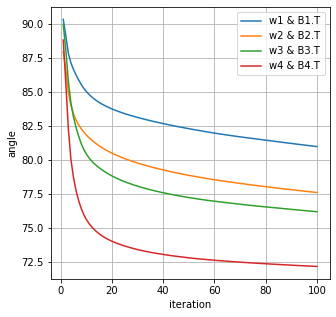

In [21]:
# angle between backward weights and forward weights
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[0,:,:].cpu().numpy(),axis=0))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[1,:,:].cpu().numpy(),axis=0))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[2,:,:].cpu().numpy(),axis=0))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[3,:,:].cpu().numpy(),axis=0))


ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.legend(['w1 & B1.T','w2 & B2.T','w3 & B3.T','w4 & B4.T'],loc='best')
ax.grid(True)

In [40]:
# alignment terms calculation

batch_size = 1000
batch_num = 60
layer_num = 4
im_size = 15*15
epoch_num = 100
input_layer = x_tr_norm.reshape((batch_num,batch_size,im_size))
a = alignment_term_cal(epoch_num,batch_num,layer_num,LR,B1,B2,B3,B4,delta5_inTime,delta4_inTime,delta3_inTime,\
                      delta2_inTime,delta1_inTime,input_layer,hidden_layer1_inTime,hidden_layer2_inTime,\
                      hidden_layer3_inTime,hidden_layer4_inTime)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


RuntimeError: ignored

In [ ]:
# cal angles between alignment terms and backwart weights.T
angles_alignment_terms = np.zeros((len(a),4))

T_k = a[-1]
for i in range(T_k.shape[0]):
    T_o = np.squeeze(T_k[i,:,:,:])
    angles_alignment_terms[i,0] = angleCal(T_o[0,:,:],B1.T)
    angles_alignment_terms[i,1] = angleCal(T_o[1,:,:],B2.T)
    angles_alignment_terms[i,2] = angleCal(T_o[2,:,:],B3.T)
    angles_alignment_terms[i,3] = angleCal(T_o[3,:,:],B4.T)


(59, 4)


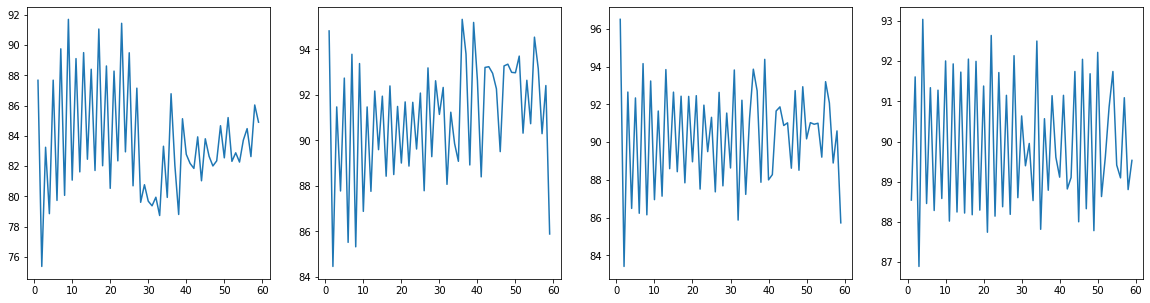

In [ ]:
print(angles_alignment_terms.shape)
fig, ax = plt.subplots(1,4,figsize=(20,5))

ax[0].plot(np.arange(1,60),angles_alignment_terms[:,0])
ax[1].plot(np.arange(1,60),angles_alignment_terms[:,1])
ax[2].plot(np.arange(1,60),angles_alignment_terms[:,2])
ax[3].plot(np.arange(1,60),angles_alignment_terms[:,3])

